Project by Krzysztof Lis for the course [Advanced logic synthesis and quantum computing](http://edu.epfl.ch/coursebook/en/advanced-logic-synthesis-and-quantum-computing-CS-724).
Acknowledgements to Prof Giovanni De Micheli and Dr Mathias Soeken.

Download files:
[qmux.ipynb](./qmux.ipynb) | 
[simulation_utils.py](./qmux_utils/simulation_utils.py)

# QMux - quantum multiplexer

Our goal is to implement a 2-qubit multiplexer quantum circuit.
It is described by two single qubit operations $U_0$, $U_1$ and it acts upon two qubits: control $c$ and target $t$.
The value of $c$ determines which of $U_0$, $U_1$ will be applied to $t$.
In a classical, non-quantum circuit, the new value of $t$ could be written like this:
$$
t' = 
\begin{cases}
U_0(t) & \text{for } c = 0\\
U_1(t) & \text{for } c = 1
\end{cases}
.
$$
However, in a quantum circuit $c$ can be in a superposition of 0 and 1.

The naive implementation using controlled gates will look like this:

![](fig/qmux_definition.svg)

Qubit operations can also be expresses as unitary matrices. $U_0$ and $U_1$ are single qubit operations so they are described by $2 \times 2$ matrices. The whole 2-qubit QMux operation is described by the following $4 \times 4$ unitary matrix: (empty spaces mean 0)
$$
\left(\begin{matrix}
U_0 & \; \\
\; & U_1 \\
\end{matrix}\right)
$$



## Qiskit

Our implementation uses [qiskit](https://qiskit.org/), an open source library for quantum circuits, allowing simulation as well as deployment on hardware.
There are several similar frameworks - you can find the alternatives in the article [Overview and Comparison of Gate Level Quantum Software Platforms](https://arxiv.org/abs/1807.02500)

### Available gates

Qiskit is targetting IBM hardware and that influences the set of available gates.
The fundamental building block for [single-qubit gates](https://qiskit.org/documentation/terra/summary_of_quantum_operations.html#single-qubit-gates) is the [u3 gate](https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/002-The_Weird_and_Wonderful_World_of_the_Qubit/004-advanced_qubit_gates.html) implementing the following unitary matrix:
$$
u3(\theta, \phi, \lambda) =
\left(\begin{matrix}
\cos(\frac{\theta}{2}) & -e^{i\lambda} \sin(\frac{\theta}{2}) \\
e^{i\phi} \sin(\frac{\theta}{2}) &  e^{i(\lambda + \phi)} \cos(\frac{\theta}{2})
\end{matrix}\right)
$$

This gate can express any single-qubit unitary matrix, Qiskit offers the function `euler_angles_1q` [[source]](https://github.com/Qiskit/qiskit-terra/blob/0.8.0/qiskit/quantum_info/synthesis/two_qubit_decompose.py#L38) which, given the unitary matrix, finds the parameters $\theta, \phi, \lambda$ up to a global phase.

These parameters are sometimes called ZYZ angles because $u3$ is equivalent to a composition of three rotations:
$$
u3(\theta, \phi, \lambda) = R_z(\phi) R_y(\theta) R_z(\lambda)
$$

There are also cheaper to implement variants of this gate:
$$
u2(\phi, \lambda) = u3(\frac{\pi}{2}, \phi, \lambda)
$$
$$
u1(\lambda) = u3(0, 0, \lambda)
$$

Other single-qubit gates are implemented using one of the $u$ gates in Qiskit, for example [Rx](https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/extensions/standard/rx.py), [H](https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/extensions/standard/h.py) or [X](https://github.com/Qiskit/qiskit-terra/blob/master/qiskit/extensions/standard/x.py).

When it comes to two qubit operations, the fundamental gate available in Qiskit is CNot.


In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['svg']

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer
import numpy as np
import matplotlib 
from matplotlib import pyplot as plt
np.set_printoptions(precision=4, suppress=True)

### Qiskit warmup

To get started with Qiskit, we try to implement the negation gate $X$: 
first using the $u3$ gate, then by performing the ZYZ rotations.

Our testing code can be found in the [`qmux_utils/simulation_utils.py` file](./qmux_utils/simulation_utils.py). The `try_..._operation` functions take a list of gates and run the simulations to get the circuit's unitary matrix, as well as a distribution of output results for the circuit.

In [3]:
from qiskit.extensions.standard import U3Gate, RZGate, RYGate
from qmux_utils.simulation_utils import *

from qiskit.quantum_info.synthesis import euler_angles_1q

def test_zyz():
#	theta, phi, lam = [np.pi, 0, np.pi]
#	theta, phi, lam = np.random.uniform(0, 2*np.pi, size=3)

	# get ZYZ angles from unitary matrix
	theta, phi, lam = euler_angles_1q(np.array([
		[0, 1],
		[1, 0],
	]))
	
	result_u3 = U3Gate(theta, phi, lam).to_matrix()
	print(f'--- X implemented as u3 - analytical matrix ---\n{result_u3}')
	
	result_u3_sim = try_1_qubit_operation (
		U3Gate(theta, phi, lam),
		print_label='X implemented as u3: simulation',
	)
	
	result_rotation =  try_1_qubit_operation(
		RZGate(lam), RYGate(theta), RZGate(phi),
		print_label='X implemented as rotations: simulation',
	)	
	
test_zyz()

--- X implemented as u3 - analytical matrix ---
[[ 0.+0.j -0.-1.j]
 [ 0.-1.j  0.+0.j]]
--- X implemented as u3: simulation ---
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]
sim: 1: 1.000
--- X implemented as rotations: simulation ---
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]
sim: 1: 1.000


## QMux - class setup

We base the class for our operation on [other Qiskit gate classes](https://github.com/Qiskit/qiskit-terra/tree/0.8.0/qiskit/extensions/standard) because we intend to contribute this implementation to Qiskit.
Below is a base abstract class - we will try several alternative implementations which will extend this class.

We represent the operations $U_0$ and $U_1$ (the ones applied to target $t$ based on the value of control $c$) by their ZYZ angles $(\theta_0, \phi_0, \lambda_0), (\theta_1, \phi_1, \lambda_1)$.
This formulation can express any single-qubit unitary and is convenient to implement using Qiskit's $u3$ gates.

In [4]:
from qiskit.circuit import Gate

class QMuxBase(Gate):
	""" Abstract base for QMux implementations"""
	
	def __init__(self, U_false_params, U_true_params):
		"""
		U0 and U1 are described by their ZYZ angles:
		QMux([theta_0, phi_0, lambda_0], [theta_1, phi_1, lambda_1])
		
		@param U_false_params: [theta_0, phi_0, lambda_0] describing U0
		@param U_true_params: [theta_1, phi_1, lambda_1] describing U1
		"""
		super().__init__("QMux", 2, [
			# here are the stored parameters describing the gate
			np.array(U_false_params, dtype=np.double), # U0
			np.array(U_true_params, dtype=np.double), #U1
		])
	
	@property
	def U_false_params(self):
		return self.params[0]
	
	@property
	def U_true_params(self):
		return self.params[1]

	def inverse(self):
		""" Inverse is QMux(U0^-1, U1^-1) """
		# TODO is this correct inversion?
		return self.__class__(-self.U_false_params, -self.U_true_params)
	
	def _define(self):
		# self.definition = list of gates
		raise NotImplementedError()


## QMux - naive decomposition

This implementation follows the simplest diagram of QMux where both $U_0$ and $U_1$ are controlled:

![](fig/qmux_definition.svg)

Since Qiskit does not have the "empty circle" controlled gates, we negate control $c$ before and after the controlled gate which applies $U_0$.

The gate diagram is shown below the code, $U_0 = u3(0.11, 0.12, 0.13)$ and $U_1 = u3(0.21, 0.22, 0.23)$ for demonstration.


In [5]:
from qiskit.extensions.standard import XGate, Cu3Gate

class QMuxNaive(QMuxBase):
	def _define(self):
		q = QuantumRegister(2, "q")
		
		self.definition = [
			(XGate(), [q[0]], []),
			(Cu3Gate(*self.U_false_params), [q[0], q[1]], []),
			(XGate(), [q[0]], []),
			(Cu3Gate(*self.U_true_params), [q[0], q[1]], []),
		]
			
draw_gate_2q(
	QMuxNaive([0.11, 0.12, 0.13], [0.21, 0.22, 0.23]), 
	disp_decomposed=False,
)

### Circuit representation and cost

We want to compare the efficiency of several implementations. In order to do that, we will check how many gates are needed to construct them and how long is the critical path.

The contorlled U3 gate visible in the diagram above is not a fundamental operation on the hardware. With the use of Qiskit's transpiler we can represent a circuit using only hardware gates.
The second diagram below this cell shows QMuxNaive's decomposition into hardware gates.

In this decomposition we can see two operations performed on one qubit one after another: a $u3$ gate followed by $u1$.
These could be more efficiently represented as a single $u3$ (which can encode any single-qubit operation).
We use Qiskit's `Optimize1qGates` optimizer to fix that, as shown in the third diagram. There are [more optimizers available](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/terra/using_the_transpiler.ipynb).

The final cost of QMuxNaive in gates is: 4 CNot, 1 $u1$, 6 $u3$; with the critical path length 9.

QMuxNaive - using high level cu3 gate




QMuxNaive - using fundamental gates
ops: 4 cx, 2 u1, 6 u3	| depth: 10


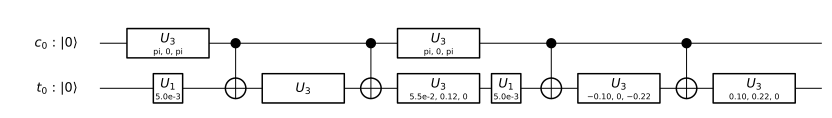



QMuxNaive - optimize consecutive gates
ops: 4 cx, 1 u1, 6 u3	| depth: 9


In [6]:
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Optimize1qGates

def circuit_stats(circ):
	print('ops: {ops}	| depth: {d}'.format(
		d = circ.depth(),
		ops = ', '.join(
			f'{count} {name}' 
			for name, count in sorted(circ.count_ops().items())
		),
	))
	
def test_transpile():
	# construct circuit with our gate
	qc = QuantumRegister(1, 'c')
	qt = QuantumRegister(1, 't')
	circ = QuantumCircuit(qc, qt)
	circ.append(QMuxNaive([0.11, 0.12, 0.13], [0.21, 0.22, 0.23]), [qc[0], qt[0]])

	print('QMuxNaive - using high level cu3 gate')
	# decompose once to see the gate's internals instead of a QMux block
	display(circ.decompose().draw(output='mpl'))
	
	print('\n\nQMuxNaive - using fundamental gates')
	circ_decomp = transpile(circ, basis_gates=['u1', 'u2', 'u3', 'cx'])
	circuit_stats(circ_decomp)
	display(circ_decomp.draw(output='mpl'))
	
	print('\n\nQMuxNaive - optimize consecutive gates')
	circ_opt = PassManager(Optimize1qGates()).run(circ_decomp)
	circuit_stats(circ_opt)
	display(circ_opt.draw(output='mpl'))
	
	
test_transpile()

## QMux - apply then undo

As we have seen above, the [controlled u3 gate](https://github.com/Qiskit/qiskit-terra/blob/0.8.0/qiskit/extensions/standard/cu3.py) is expensive as it contains two `CNot`s, two $u3$ gates and a $u1$ gate.

In order to improve the efficiency of our solution, we can apply $U_0$ to the target qubit always, and "if" the control value is 1, undo $U_0$ and apply $U_1$. This way we use only one controlled $u3$ instead of two.
The unitary matrix for *undo $U_0$ and apply $U_1$* is $U_1 U_0^\dagger$.

![](fig/qmux_definition.svg)

![](fig/qmux_compose_1.svg)

The implementation is shown below. This variant's cost is 2 CNot, 3 $u3$ with critical path of 5; we managed to reduce the cost of the naive solutions by half.

Decomposed: ops: 2 cx, 1 u1, 3 u3	| depth: 6


Optimized: ops: 2 cx, 3 u3	| depth: 5


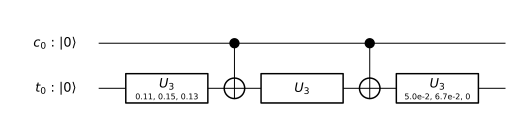

In [7]:
from qiskit.extensions.standard import U3Gate, Cu3Gate
from qiskit.transpiler.passes.optimize_1q_gates import Optimize1qGates

class QMuxUndo(QMuxBase):
	def _define(self):
		q = QuantumRegister(2, "q")
		
		#comp = -theta_false, -phi_false, -lambda_false, theta_true, phi_true, lambda_true
		comp = np.concatenate([-self.U_false_params, self.U_true_params])
		
		undo_Uf_apply_Ut_params = Optimize1qGates.compose_u3(*comp)

		self.definition = [
			(U3Gate(*self.U_false_params), [q[1]], []),
			(Cu3Gate(*undo_Uf_apply_Ut_params), [q[0], q[1]], []),
		]
		
draw_gate_2q(QMuxUndo([0.11, 0.12, 0.13], [0.21, 0.22, 0.23]), disp_optimized=True)

## QMux - diagonalization

Finally, we use the construction proposed by Vivek V. Shende et al. in [Synthesis of Quantum Logic Circuits](https://arxiv.org/abs/quant-ph/0406176).

The unitary matrix of QMux is decomposed in the following way:

$$
\left(\begin{matrix}
U_0 & \; \\
\; & U_1 
\end{matrix}\right)
=
\left(\begin{matrix}
V_1 & \; \\
\; & V_1 
\end{matrix}\right)
\left(\begin{matrix}
D & \; \\
\; & D^\dagger
\end{matrix}\right)
\left(\begin{matrix}
V_0 & \; \\
\; & V_0
\end{matrix}\right)
,
$$
Where $D$ is a diagonal matrix and the empty spaced denote $2 \times 2$ areas of 0s. We perform further steps to determine the value of $V_0$, $V_1$ and $D$:

$$U_0 = V_1 D V_0$$
$$U_1 = V_1 D^\dagger V_0$$
$$U' = U_0 U_1^\dagger = V_1 D^2 V_1^\dagger$$

We extract the eigenvalues $\lambda_1$, $\lambda_2$ of $U'$ and the corresponding eigenvectors $v_1$, $v_2$.
$V_1$ is a matrix whose columns are $v_1$, $v_2$.

$$V_1 = ( v_1 | v_2 )$$

$$
D = \left(\begin{matrix}
\sqrt{\lambda_1} & 0 \\
0 & \sqrt{\lambda_2}
\end{matrix}\right)
$$

$$V_0 = D^\dagger V_1^\dagger U_0$$

Further derivation, given on page 36 of our script, yield the following circuit: (with $\theta_1 = arg(\sqrt{\lambda_1})$, $\theta_2 = arg(\sqrt{\lambda_2})$)

![](fig/qmux_diagonalization.svg)

The implementation is given below. It costs 2 CNot, 2 $u1$, 2 $u3$. Compared to the previous version, we remove a $u3$ but add a $u1$ gate.
This is an improvement as according to the [documentation](https://quantumexperience.ng.bluemix.net/proxy/tutorial/full-user-guide/002-The_Weird_and_Wonderful_World_of_the_Qubit/004-advanced_qubit_gates.html), $u1$ "is implemented as a frame change, and takes zero time" while $u3$ "is implemented using three frame changes and two $X_{\pi/2}$ pulses".

Decomposed: ops: 2 cx, 2 u1, 2 u3	| depth: 5


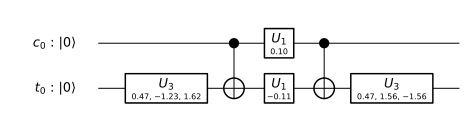

In [8]:
from qiskit.extensions.standard import U3Gate, CnotGate, RZGate
from qiskit.quantum_info.synthesis import euler_angles_1q

class QMuxDiagonalization(QMuxBase):
	def _define(self):
		q = QuantumRegister(2, "q")
		
		U0 = U3Gate(*self.U_false_params).to_matrix()
		U1 = U3Gate(*self.U_true_params).to_matrix()

		# U'
		U0_U1inv = U0 @ U1.conj().T

		# (\lambda_1, \lambda_2), (v_1, v_2)
		eigvals, eigvec_as_rows = np.linalg.eig(U0_U1inv)

		# V1 is a matrix whose columns are v_1 v_2
		V1 = eigvec_as_rows.T

		D = np.diag(np.sqrt(eigvals))

		V0 = D.conj().T @ V1.conj().T @ U0

		theta1 = -np.angle(eigvals[0])
		theta2 = -np.angle(eigvals[1])

		self.definition = [
			(U3Gate(*euler_angles_1q(V0)), [q[1]], []),
			(CnotGate(), [q[0], q[1]], []),
			(RZGate(0.5*(theta1 + theta2)), [q[0]], []),
			(RZGate(0.5*(theta1 - theta2)), [q[1]], []),
			(CnotGate(), [q[0], q[1]], []),
			(U3Gate(*euler_angles_1q(V1)), [q[1]], []),
		]
		
draw_gate_2q(
	QMuxDiagonalization([0.11, 0.12, 0.13], [0.21, 0.22, 0.23]), 
	disp_optimized=False,
)

## Testing the implementations

Let us test if the implementations work as expected. To that end we will use the test circuit shown below;
the control qubit is put in an equal superposition of true and false by the Hadamard gate. Then the QMux gate transforms the target qubit according to the $U_0$ and $U_1$ operations we have specified. Finally both qubits are measured yielding classical values.

![](fig/test_env.svg)

We also compare the $4 \times 4$ unitary matrices of the operations.
To remove global phase, we divide the matrix by its first element ($B / B_{11}$). We then report the Frobenius norm of its difference to the ground truth matrix $A$:
$$\text{diff} = \left\lVert \frac{A}{A_{11}} - \frac{B}{B_{11}} \right\rVert_F$$


#### Test: CNot

CNot is equivalent to $QMux(I, X)$. We compare the native CNot to our implementations.

In [13]:
from qiskit.extensions.standard import CnotGate

def compare_2qubit_implementations(task_name, gate_dict, gt_unitary = None):
	for name, gate in gate_dict.items():
		gate = [gate] if not isinstance(gate, (tuple, list)) else gate
		try_2_qubit_operation(*gate, print_label = f'{task_name}: {name}', gt_unitary=gt_unitary)
		print('\n')

def build_qmux_matrix(U_false, U_true):
	z2 = np.zeros((2, 2), dtype=np.complex)
	unitary = np.concatenate([
		np.concatenate([U_false, z2], axis=1),
		np.concatenate([z2, U_true], axis=1),
	], axis=0)
	
	return unitary
	
def build_qmux_matrix_zyz(zyz_false, zyz_true):
	U_false = U3Gate(*zyz_false).to_matrix()
	U_true = U3Gate(*zyz_true).to_matrix()
	return build_qmux_matrix(U_false, U_true)
	

def qmux_vs_cnot():
	print('\nCNOT')

	U_false = np.eye(2)
	U_true = np.array([[0, 1], [1, 0]])
	
	# when control is false: identity
	zyz_false = [0, 0, 0]
	# when control is true: negation
	zyz_true = [np.pi, 0, np.pi]

	gt_unitary = build_qmux_matrix(U_false, U_true)
	
	compare_2qubit_implementations('CNot', {
		'cnot': CnotGate(),
		'naive': QMuxNaive(zyz_false, zyz_true),
		'undo': QMuxUndo(zyz_false, zyz_true),
		'diagonalization': QMuxDiagonalization(zyz_false, zyz_true),
	}, gt_unitary = gt_unitary)

qmux_vs_cnot()


CNOT
--- CNot: cnot ---
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]
sim: 00: 0.497	11: 0.503
unitary difference: 0.000


--- CNot: naive ---
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]]
sim: 00: 0.504	11: 0.496
unitary difference: 2.000


--- CNot: undo ---
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]]
sim: 00: 0.504	11: 0.496
unitary difference: 2.000


--- CNot: diagonalization ---
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]]
sim: 00: 0.504	11: 0.496
unitary difference: 0.000




#### Test: Controlled H

[Controlled H](https://github.com/Qiskit/qiskit-terra/blob/0.8.0/qiskit/extensions/standard/ch.py) is equivalent to $QMux(I, H)$.

In [17]:
from qiskit.extensions.standard import CHGate

def qmux_vs_ch():
	H_mat = np.array([
		[1, 1],
		[1, -1],
	]) / np.sqrt(2)
	
	# when control is false: identity
	zyz_false = [0, 0, 0]
	# when control is true: H
	#zyz_true = euler_angles_1q(H_mat)
	zyz_true = [np.pi*0.5, 0, np.pi]
	
	print('id zyz', zyz_false, 'H zyz', zyz_true)
	

	gt_unitary = build_qmux_matrix(np.eye(2), H_mat)
	
	
	compare_2qubit_implementations('Controlled H', {
		'cH': CHGate(),
		'naive': QMuxNaive(zyz_false, zyz_true),
		'undo': QMuxUndo(zyz_false, zyz_true),
		'diagonalization': QMuxDiagonalization(zyz_false, zyz_true),
	}, gt_unitary=gt_unitary)
	
qmux_vs_ch()

id zyz [0, 0, 0] H zyz [1.5707963267948966, 0, 3.141592653589793]
--- Controlled H: cH ---
[[ 0.7071-0.7071j  0.    +0.j      0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.7071-0.7071j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.5   -0.5j     0.5   -0.5j   ]
 [ 0.    +0.j      0.    +0.j      0.5   -0.5j    -0.5   +0.5j   ]]
sim: 00: 0.500	10: 0.246	11: 0.255
unitary difference: 0.000


--- Controlled H: naive ---
[[1.+0.j     0.+0.j     0.+0.j     0.+0.j    ]
 [0.+0.j     1.+0.j     0.+0.j     0.+0.j    ]
 [0.+0.j     0.+0.j     0.-0.7071j 0.-0.7071j]
 [0.+0.j     0.+0.j     0.-0.7071j 0.+0.7071j]]
sim: 00: 0.500	10: 0.246	11: 0.255
unitary difference: 2.000


--- Controlled H: undo ---
[[1.+0.j     0.+0.j     0.+0.j     0.+0.j    ]
 [0.+0.j     1.+0.j     0.+0.j     0.+0.j    ]
 [0.+0.j     0.+0.j     0.-0.7071j 0.-0.7071j]
 [0.+0.j     0.+0.j     0.-0.7071j 0.+0.7071j]]
sim: 00: 0.500	10: 0.246	11: 0.255
unitary difference: 2.000


--- Controlled H: 

#### Test: Random unitaries

We test QMux with random $U_0$, $U_1$ generated by choosing random $\theta, \phi, \lambda$ angles.
The unitary matrix of $QMux(U_0, U_1)$ is:
$$
U_{qmux} = \left(\begin{matrix}
U_0 & \; \\
\; & U_1 \\
\end{matrix}\right)
$$
The input state that is given to QMux by our test circuit is $|ct\rangle = \frac{1}{\sqrt{2}}( |00\rangle + |10\rangle )$, because we start from $|00\rangle$ and apply H to the control qubit.
We apply $U_{qmux}$ to this state vector to obtain the analytical outputs of this circuit, to then compare it with the simulation results of our implementations.



In [20]:
from qiskit.extensions.standard import U3Gate

def qmux_vs_random_unitary():
	# generate random U0 U1
	zyz_false = np.random.uniform(0, 2*np.pi, size=3)
	zyz_true = np.random.uniform(0, 2*np.pi, size=3)
	U_false = U3Gate(*zyz_false).to_matrix()
	U_true = U3Gate(*zyz_true).to_matrix()
	
	# Build the unitary for Qmux(U0, U1)
# 	z2 = np.zeros((2, 2), dtype=np.complex)
# 	analytical_unitary = np.concatenate([
# 		np.concatenate([U_false, z2], axis=1),
# 		np.concatenate([z2, U_true], axis=1),
# 	], axis=0)
	
	analytical_unitary = build_qmux_matrix_zyz(zyz_false, zyz_true)
	
	
	# analytical input to Qmux, |ct> equal superposition of 00 and 10 caused by applying H to the control bit
	analytical_input_state = np.array([1, 0, 1, 0]) / np.sqrt(2)
	
	# apply the unitary, measure the probabilities
	analytical_out_state = analytical_unitary @ analytical_input_state
	analytical_probabilities = np.real(analytical_out_state * analytical_out_state.conj())
	
	print('Analytical_unitary\n', analytical_unitary)
	
	print('Analytical probabilities\n', result_to_str({
		np.binary_repr(i, width=2): val for i, val in enumerate(analytical_probabilities)
	}))
	print('\n')
	
	compare_2qubit_implementations('Random unitary', {
		'naive': QMuxNaive(zyz_false, zyz_true),
		'undo': QMuxUndo(zyz_false, zyz_true),
		'diagonalization': QMuxDiagonalization(zyz_false, zyz_true),
	}, gt_unitary = analytical_unitary)
	
qmux_vs_random_unitary()

Analytical_unitary
 [[-0.6487+0.j      0.0034+0.761j   0.    +0.j      0.    +0.j    ]
 [-0.7405+0.1757j -0.1526-0.6305j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j      0.8355+0.j      0.5491-0.0198j]
 [ 0.    +0.j      0.    +0.j      0.5109+0.2024j -0.7874-0.2795j]]
Analytical probabilities
 00: 0.210	01: 0.290	10: 0.349	11: 0.151


--- Random unitary: naive ---
[[ 0.5098-0.4012j -0.4733-0.596j   0.    +0.j      0.    +0.j    ]
 [ 0.4733-0.596j   0.5098+0.4012j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j     -0.1418-0.8234j -0.1128-0.5378j]
 [ 0.    +0.j      0.    +0.j      0.1128-0.5378j -0.1418+0.8234j]]
sim: 00: 0.212	01: 0.284	10: 0.355	11: 0.150
unitary difference: 3.746


--- Random unitary: undo ---
[[-0.6487+0.j      0.0034+0.761j   0.    +0.j      0.    +0.j    ]
 [-0.7405+0.1757j -0.1526-0.6305j  0.    +0.j      0.    +0.j    ]
 [ 0.    +0.j      0.    +0.j     -0.4521+0.5055j  0.6164-0.4001j]
 [ 0.    +0.j      0.    +0.j      0.244 

## Conclusion

The tests show that our implementations produce approximately correct probabilities (looking at the results of classically measuring the states) but they differ in phase to the ground truth matrix. In future work we will attempt to find the reason for the phase difference.
